The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import copy
from collections import namedtuple, deque

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [12]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
CONFIG = namedtuple('config', 
                    [
                     'state_size',
                     'action_size',
                     'buffer_size',  # replay buffer size
                     'batch_size',   # minibatch size
                     'gamma',        # discount factor
                     'tau',          # for soft update of target parameters
                     'lr_actor',     # learning rate of the actor
                     'lr_critic',    # learning rate of the critic
                     'weight_decay', # L2 weight decay
                     'random_seed',
                     'device',
                     'agents',
                     'noise_decay',
                     'noise_final',
                     'learn_steps',
                    ])
config = CONFIG(state_size, action_size, int(1e5), 256, 0.99, 1e-3, 1e-4, 3e-4, 0.000, 10, 
                device, num_agents, 0.999, 0.1, 5)

print ('state_size: {}'.format(config.state_size))
print ('action_size: {}'.format(config.action_size))
print ('buffer_size: {}'.format(config.buffer_size))
print ('batch_size: {}'.format(config.batch_size))
print ('gamma: {}'.format(config.gamma))
print ('tau: {}'.format(config.tau))
print ('lr_actor: {}'.format(config.lr_actor))
print ('lr_critic: {}'.format(config.lr_critic))
print ('weight_decay: {}'.format(config.weight_decay))
print ('random_seed: {}'.format(config.random_seed))
print ('device: {}'.format(config.device))
print ('agents: {}'.format(config.agents))
print ('noise decay: {}'.format(config.noise_decay))
print ('noise final: {}'.format(config.noise_final))
print ('learn steps: {}'.format(config.learn_steps))

state_size: 24
action_size: 2
buffer_size: 100000
batch_size: 256
gamma: 0.99
tau: 0.001
lr_actor: 0.0001
lr_critic: 0.0003
weight_decay: 0.0
random_seed: 10
device: cuda:0
agents: 2
noise decay: 0.999
noise final: 0.1
learn steps: 5


In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed = 123, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=123, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.elu(self.fc2(x))

        return self.fc3(x)
                                      

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", \
                                    "reward", "next_state", "done", "full_state", "full_next_state"])
        self.seed = random.seed(seed)
        self.device = device

    def add(self, state, action, reward, next_state, done, full_state, full_next_state):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done, full_state, full_next_state)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).\
                                  float().to(self.device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).\
                                  float().to(self.device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).\
                                  float().to(self.device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).\
                                  float().to(self.device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).\
                                  float().to(self.device)
        full_state = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).\
                                  float().to(self.device)
        full_next_state = torch.from_numpy(np.array([e.full_next_state for e in experiences if e is not None])).\
                                  float().to(self.device)
        return (states, actions, rewards, next_states, dones, full_state, full_next_state)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
        

In [9]:
class Agent(object):
    """Interacts with and learns from the environment."""

    def __init__(self, config):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = config.state_size
        self.action_size = config.action_size
        self.seed = random.seed(config.random_seed)
        self.random_seed = config.random_seed
        self.tau = config.tau
        self.gamma = config.gamma
        self.device = config.device
        self.buffer_size = config.buffer_size
        self.batch_size = config.batch_size
        self.lr_actor = config.lr_actor
        self.lr_critic = config.lr_critic
        self.weight_decay = config.weight_decay
        self.agents = config.agents
        self.learn_steps = config.learn_steps

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, self.action_size, self.random_seed).to(self.device)
        self.actor_target = Actor(self.state_size, self.action_size, self.random_seed).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.lr_actor, \
                                          weight_decay=self.weight_decay)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(self.agents*self.state_size, self.agents*self.action_size, \
                                   self.random_seed).to(self.device)
        self.critic_target = Critic(self.agents*self.state_size, self.agents*self.action_size, \
                                    self.random_seed).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.lr_critic, \
                                           weight_decay=self.weight_decay)

        # Noise process
        self.noise = OUNoise(self.action_size, self.random_seed)
        self.noise_scale = 1.0
        self.noise_final = config.noise_final
        self.noise_decay = config.noise_decay
        
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        self.noise_scale = self.noise_scale * self.noise_decay
        self.noise_scale = max(self.noise_scale, self.noise_final)

        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * self.noise_scale
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, actions_next, actions_pred, agent_number):        
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, full_state, full_next_state  = experiences
        #agent_state = states[:, agent_number, :]
        agent_reward = rewards[:, agent_number].view(-1, 1)
        agent_done   = dones[:, agent_number].view(-1, 1)
        full_actions = actions.view(-1, self.agents*self.action_size)
 
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        Q_targets_next = self.critic_target(full_next_state, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = agent_reward + (gamma * Q_targets_next * (1 - agent_done))
        # Compute critic loss
        Q_expected = self.critic_local(full_state, full_actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ------------------------
        # Compute actor loss
        #actions_pred = actions.clone()
        #actions_pred[:, agent_number, :]  = self.actor_local(agent_state)
        #actions_pred = actions_pred.view(-1, self.action_size * self.agents)
        actor_loss = -self.critic_local(full_state, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)      

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self, filename):
        torch.save(self.actor_local.state_dict(), '%s_actor.pth' % (filename))
        torch.save(self.critic_local.state_dict(), '%s_critic.pth' % (filename))

    def load(self, filename):
        self.actor_local.load_state_dict(torch.load('%s_actor.pth' % filename))
        self.critic_local.load_state_dict(torch.load('%s_critic.pth' % filename))

    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)

In [10]:
class MADDPG(object):
    def __init__(self, config):
        super(MADDPG, self).__init__()
        self.batch_size = config.batch_size
        self.learn_steps = config.learn_steps
        self.gamma = config.gamma
        self.action_size = config.action_size
        self.device = config.device

        self.replay_buffer = ReplayBuffer(config.buffer_size, config.batch_size,
                                          config.random_seed, config.device)
        self.maddpg_agent = [ Agent(config) for _ in range(config.agents) ]

    def act(self, states):
        result = []
        for i, agent in enumerate(self.maddpg_agent):
            action = agent.act(np.reshape(states[i, :], newshape=(1, -1)))
            action = np.reshape(action, newshape=(1, -1))
            result.append(action)
        return np.concatenate(result, axis = 0)

    def reset(self):
        for agent in self.maddpg_agent:
            agent.reset()
            
    def step(self, states, actions, rewards, next_states, dones):
        full_state = np.reshape(states, newshape=(-1))
        full_next_states = np.reshape(next_states, newshape=(-1))

        self.replay_buffer.add(states, actions, rewards, next_states, dones, full_state, full_next_states)
        if len(self.replay_buffer) > self.batch_size:
            for _ in range(self.learn_steps):
                experience = self.replay_buffer.sample()
                for i in range(len(self.maddpg_agent)):
                    self.learn(experience, self.gamma, i)

    def learn(self, experience, gamma, agent_number):
        states, actions, rewards, next_states, dones, full_state, full_next_states = experience
        #get the critic predicted response including all agents
        actions_next = torch.zeros(states.shape[:2] + (self.action_size,), dtype = torch.float, device = self.device)
        for i, agent in enumerate(self.maddpg_agent):
            next_state = next_states[:,i,:]
            actions_next[:,i,:] = agent.actor_target(next_state)
        actions_next = actions_next.view(-1, self.action_size * len(self.maddpg_agent))
 
        agent = self.maddpg_agent[agent_number]
        agent_state = states[:, agent_number, :]
        actions_pred = actions.clone()
        actions_pred[:, agent_number, :]  = agent.actor_local(agent_state)
        actions_pred = actions_pred.view(-1, self.action_size * len(self.maddpg_agent))

        agent.learn(experience, gamma, actions_next, actions_pred, agent_number)

    def save(self, filename):
        for i,agent in enumerate(self.maddpg_agent):
            name = 'agent{}_{}'.format(i, filename)
            agent.save(name)

    def load(self, filename):
        for i,agent in enumerate(self.maddpg_agent):
            name = 'agent{}_{}'.format(i, filename)
            agent.load(name)



In [11]:
agent = MADDPG(config)

In [12]:
def maddpg(n_episodes=2500, max_t = 2000, print_every=100, window_size = 100, target = 0.5):
    scores_deque = deque(maxlen=window_size)
    scores = []
    flag = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            score += np.array(rewards)
            if np.any(dones):
                break 
        
        max_score = score.max()
        scores_deque.append(max_score)
        scores.append(max_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode {}\tAverage Score: {:.2f}, score: {:.2f}'.format(i_episode, average_score, max_score), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))

        if average_score >= target and not flag:
            print ('\rSolved in Episode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
            agent.save('checkpoint')
            flag = True
            #break

    return scores


In [13]:
scores = maddpg()

Episode 100	Average Score: 0.01, score: 0.00
Episode 200	Average Score: 0.00, score: 0.00
Episode 300	Average Score: 0.00, score: 0.00
Episode 400	Average Score: 0.02, score: 0.00
Episode 500	Average Score: 0.05, score: 0.00
Episode 600	Average Score: 0.06, score: 0.09
Episode 700	Average Score: 0.06, score: 0.09
Episode 800	Average Score: 0.08, score: 0.10
Episode 900	Average Score: 0.08, score: 0.00
Episode 1000	Average Score: 0.08, score: 0.10
Episode 1100	Average Score: 0.11, score: 0.30
Episode 1200	Average Score: 0.13, score: 0.30
Episode 1300	Average Score: 0.17, score: 0.10
Episode 1400	Average Score: 0.18, score: 0.19
Episode 1500	Average Score: 0.16, score: 0.20
Episode 1600	Average Score: 0.23, score: 0.70
Episode 1700	Average Score: 0.26, score: 0.10
Episode 1800	Average Score: 0.29, score: 0.10
Episode 1900	Average Score: 0.43, score: 0.80
Solved in Episode 1914	Average Score: 0.51.30
Episode 2000	Average Score: 0.70, score: 0.30
Episode 2100	Average Score: 0.48, score: 1.

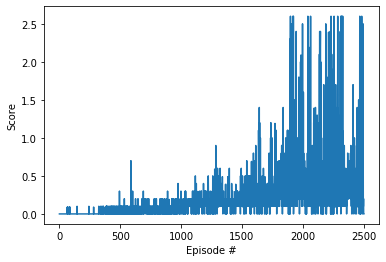

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()